# PCA Autoencoder (Part 4)

In this notebook, we will implement a hierarchical PCA autoencoder with 2 subnetworks (i.e., a total of 3 latent codes in the end) to decompose the synthetic dataset of binary ellipses with 3 variables (size, axes and rotation). The dataset will be generated using the same method in [Part 2](pca_ae_rotation). The effectiveness of the additional hierarchy will be compared with the plain autoencoder with latent covariance loss. Specifically for this part, we will also rewrite the custom layer for the latent covariance loss so that it could handle different dimensions of the latent space.

## Setup

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage.transform import rotate

np.random.seed(42)
tf.random.set_seed(42)

Standard encoder and decoder as used in [Part 3](pca_ae_hierarchy).

In [ ]:
def encoder_gen(inputs):
    x = keras.layers.Conv2D(4, (3, 3), padding='same')(inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(8, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1)(x)

    return x

def decoder_gen(inputs):
    x = keras.layers.Dense(16)(inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Reshape((2, 2, 4))(x)
    x = keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same')(x)

    return x

A function for assigning unique names to the sub-networks.

In [ ]:
def edit_name(model, name):
  for layer in model.layers:
      layer._name = name + '_' + layer._name 
  for i in range(len(model.weights)):
      model.weights[i]._handle_name = name + '_' + model.weights[i].name

Synthesize the dataset of ellipses. To be consistent with [Part 2](pca_ae_rotation), we will use a total number of 32 batches.

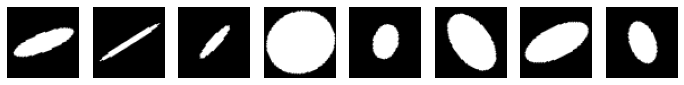

In [ ]:
def phantomEllipse_ang(n, a, b, ang):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return rotate(img, angle=ang)

n = 64
num_batch = 32
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
ang = random_gen.uniform(0, 90, N)
dataset = np.array([phantomEllipse_ang(n, _a, _b, _ang) for _a, _b, _ang in zip(a, b, ang)])
dataset = dataset[..., np.newaxis]

frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ..., 0], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

### Latent covariance loss

The custom layer is modified below to accommodate variable sizes in the latent space. Here I will compute the covariance between all possible pairs of latent codes. In the original work, the authors only accounted for the covariances between the new additional code and the existing (trained) codes, since the trained codes should already be optimized with each other. My intention, however, is to be able to use this custom layer in non-hierarchical autoencoders.

In [ ]:
class LatentCovarianceLayer(keras.layers.Layer):
    def __init__(self, lam=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam
    def call(self, inputs):
        _sum = 0.0
        for _indices in list(itertools.combinations(range(inputs.shape[-1]), 2)):
            _sum += tf.math.reduce_mean(
                tf.math.multiply(inputs[:, _indices[0]], inputs[:, _indices[1]]))
        
        covariance = self.lam * _sum
        self.add_loss(tf.math.abs(covariance))
        self.add_metric(tf.abs(covariance), name='cov_loss')
        return inputs
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "lam":self.lam}

## First autoencoder

### Train the first network

In [ ]:
# SCROLL
keras.backend.clear_session()
input_img = keras.layers.Input(shape=[64, 64, 1])
encoded = encoder_gen(input_img)
decoded = decoder_gen(encoded)
pca_ae = keras.models.Model(input_img, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_0.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
32/32 [==============================] - 31s 53ms/step - loss: 0.1781

Epoch 00001: loss improved from inf to 0.17812, saving model to ./model_0.hdf5
Epoch 2/1000
32/32 [==============================] - 2s 52ms/step - loss: 0.0935

Epoch 00002: loss improved from 0.17812 to 0.09349, saving model to ./model_0.hdf5
Epoch 3/1000
32/32 [==============================] - 2s 51ms/step - loss: 0.0637

Epoch 00003: loss improved from 0.09349 to 0.06374, saving model to ./model_0.hdf5
Epoch 4/1000
32/32 [==============================] - 2s 50ms/step - loss: 0.0604

Epoch 00004: loss improved from 0.06374 to 0.06038, saving model to ./model_0.hdf5
Epoch 5/1000
32/32 [==============================] - 2s 52ms/step - loss: 0.0580

Epoch 00005: loss improved from 0.06038 to 0.05798, saving model to ./model_0.hdf5
Epoch 6/1000
32/32 [==============================] - 2s 51ms/step - loss: 0.0556

Epoch 00006: loss improved from 0.05798 to 0.05560, saving model to ./model_0.hdf5
Epoch 7

In [ ]:
model_0 = keras.models.load_model('model_0.hdf5')

In [ ]:
edit_name(model_0, 'model_0')

### Examine the result

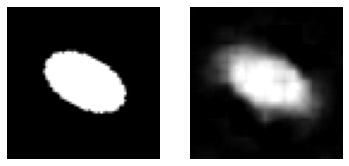

In [ ]:
img = dataset[1430, ...]
img_rec = model_0.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

In [ ]:
decoder_0 = keras.models.Sequential(model_0.layers[-12:])
encoder_0 = keras.models.Model(inputs=model_0.input, outputs=model_0.get_layer('latent_covariance_layer').output)

During my tests, the first autoencoder sometimes could not capture the rotation of the ellipses at all. Overall the reconstruction quality is visibly worse than in the case of only two variables in the dataset.

## Second autoencoder

I tried different $\lambda$ and landed with 0.3 that offered a good comprise between the distinction of features and interpretability of the latent codes.

In [ ]:
keras.backend.clear_session()
encoder_0.trainable = False
input_img = keras.layers.Input(shape=[64, 64, 1])
encoded_1 = encoder_gen(input_img)
encoded_0 = encoder_0(input_img)
concat = keras.layers.Concatenate()([encoded_0, encoded_1])
batchnorm = keras.layers.BatchNormalization(center=False, scale=False)(concat)
add_loss = LatentCovarianceLayer(0.3)(batchnorm)
decoded_1 = decoder_gen(add_loss)
pca_ae = keras.models.Model(input_img, decoded_1)

In [ ]:
# SCROLL
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_1.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
32/32 [==============================] - 3s 65ms/step - loss: 0.2513 - cov_loss: 0.0829

Epoch 00001: loss improved from inf to 0.25126, saving model to ./model_1.hdf5
Epoch 2/1000
32/32 [==============================] - 2s 62ms/step - loss: 0.1083 - cov_loss: 0.0172

Epoch 00002: loss improved from 0.25126 to 0.10832, saving model to ./model_1.hdf5
Epoch 3/1000
32/32 [==============================] - 2s 62ms/step - loss: 0.0767 - cov_loss: 0.0173

Epoch 00003: loss improved from 0.10832 to 0.07675, saving model to ./model_1.hdf5
Epoch 4/1000
32/32 [==============================] - 2s 63ms/step - loss: 0.0631 - cov_loss: 0.0127

Epoch 00004: loss improved from 0.07675 to 0.06311, saving model to ./model_1.hdf5
Epoch 5/1000
32/32 [==============================] - 2s 62ms/step - loss: 0.0660 - cov_loss: 0.0200

Epoch 00005: loss did not improve from 0.06311
Epoch 6/1000
32/32 [==============================] - 2s 62ms/step - loss: 0.0597 - cov_loss: 0.0164

Epoch 00006: 

In [ ]:
model_1 = keras.models.load_model('model_1.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})

### Examine the result

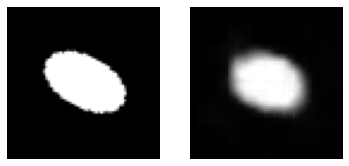

In [ ]:
img = dataset[1430, ...]
img_rec = model_1.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

In [ ]:
decoder_1 = keras.models.Sequential(model_1.layers[-12:])
encoder_1 = keras.models.Model(inputs=model_1.input, outputs=model_1.get_layer('latent_covariance_layer').output)

The improvement in reconstruction is obvious after the introduction of the second latent code.

In [ ]:
pca_ae_decoder = keras.models.Sequential(model_1.layers[-12:])

We can have a look at how the latent codes behave, just as we did in previous parts of this series.

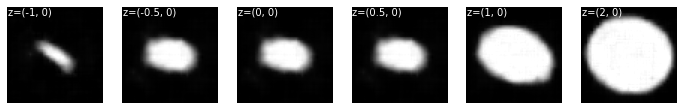

In [ ]:
vals = [-1, -0.5, 0, 0.5, 1, 2]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

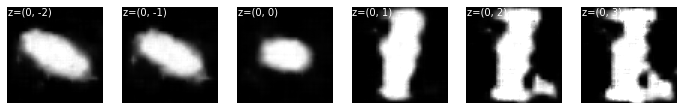

In [ ]:
vals = [-2, -1, 0, 1, 2, 3]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()

It is quite interesting to observe that, the autoencoder is able to separate the primary features (size and axes) as it did before with the dataset of 2-variable ellipses. However, the rotation seems to be encoded in both latent codes.

## Third autoencoder

Now we can add one more code to the latent space.

In [ ]:
keras.backend.clear_session()
encoder_1.trainable = False
input_img = keras.layers.Input(shape=[64, 64, 1])
encoded_2 = encoder_gen(input_img)
encoded_1 = encoder_1(input_img)
concat = keras.layers.Concatenate()([encoded_1, encoded_2])
batchnorm = keras.layers.BatchNormalization(center=False, scale=False)(concat)
add_loss = LatentCovarianceLayer(0.3)(batchnorm)
decoded_2 = decoder_gen(add_loss)
pca_ae = keras.models.Model(input_img, decoded_2)

In [ ]:
# SCROLL
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_2.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
32/32 [==============================] - 4s 76ms/step - loss: 0.2266 - cov_loss: 0.0565

Epoch 00001: loss improved from inf to 0.22656, saving model to ./model_2.hdf5
Epoch 2/1000
32/32 [==============================] - 2s 74ms/step - loss: 0.1157 - cov_loss: 0.0148

Epoch 00002: loss improved from 0.22656 to 0.11567, saving model to ./model_2.hdf5
Epoch 3/1000
32/32 [==============================] - 2s 74ms/step - loss: 0.0817 - cov_loss: 0.0212

Epoch 00003: loss improved from 0.11567 to 0.08168, saving model to ./model_2.hdf5
Epoch 4/1000
32/32 [==============================] - 2s 74ms/step - loss: 0.0687 - cov_loss: 0.0185

Epoch 00004: loss improved from 0.08168 to 0.06870, saving model to ./model_2.hdf5
Epoch 5/1000
32/32 [==============================] - 2s 73ms/step - loss: 0.0561 - cov_loss: 0.0107

Epoch 00005: loss improved from 0.06870 to 0.05610, saving model to ./model_2.hdf5
Epoch 6/1000
32/32 [==============================] - 2s 74ms/step - loss: 0.05

In [ ]:
model_2 = keras.models.load_model('model_2.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})

### Examine the result

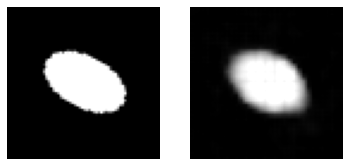

In [ ]:
img = dataset[1430, ...]
img_rec = model_2.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

There is no significant improvement in reconstruction with the addition of the third latent code.

In [ ]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 4)    0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

Notice that the non-trainable parameters come from the first two encoders.

In [ ]:
decoder_2 = keras.models.Sequential(model_2.layers[-12:])
encoder_2 = keras.models.Model(inputs=model_2.input, outputs=model_2.get_layer('latent_covariance_layer').output)

In [ ]:
pca_ae_decoder = keras.models.Sequential(model_2.layers[-12:])

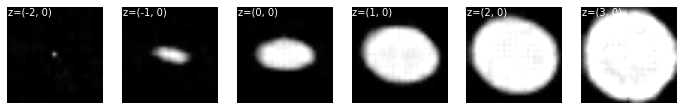

In [ ]:
vals = [-2, -1, 0, 1, 2, 3]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[vals[i], 0, 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

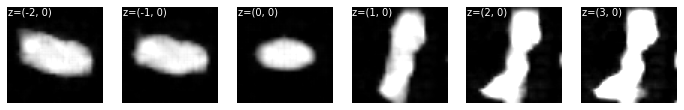

In [ ]:
vals = [-2, -1, 0, 1, 2, 3]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

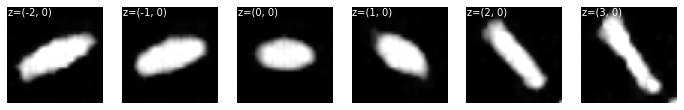

In [ ]:
vals = [-2, -1, 0, 1, 2, 3]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, 0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

So now with 3 latent codes in the system, the three variables are separated relatively well among the latent codes, with the first code representing the size, the second the axes and the third the rotation. I think the results can be further improved by optimizing the models and the value of $\lambda$.

## Conclusions

This series is almost coming to an end. I have one last comparison left to do in the next part, namely with just the standard PCA. From the preceding notebooks we can conclude that, the PCA autoencoders seem to distinguish the patterns encoded in the dataset differently than how it is mathematically generated. For the dataset, we used two variables $a$ and $b$ to control the size and orientation (horizontal/vertical) of the ellipses. The autoencoders "cleverly" identified two features in the dataset, i.e., size (represented by a circle) and the ratio between the two axes of the ellipses, which controls the "length" of the vertical or horizontal ellipses. The advantage of this feature separation is perhaps that, while $a$ and $b$ in the mathematical formula cannot be zero, both the size and the ratio are well-defined at 0.

At least based on my tests, the hierarchy scheme doesn't seem to offer significant advantage over a plain PCA autoencoder that is much easier to implement. The method may prove more useful in cases where different features in the dataset have different levels of "prominence".